## Group 10 Final Assignment

**Data Source:**

Historical Plane Crash Data - https://www.kaggle.com/datasets/abeperez/historical-plane-crash-data





Objective:
Using only information available at or immediately after a recorded plane crash, estimate survivability by predicting:
(a) the probability that a crash will have any survivors (yes/no)
(b) the expected number of survivors

1. Classification objective: Predict whether a crash will have any survivors (Yes/No).
    - Outputs: probability p(any survivors) and a class label after thresholding.
2. Regression objective: Estimate the number of survivors in the crash.
    - Outputs: non-negative survivor count prediction.


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


np.random.seed(123)
plt.rcParams.update({
     "axes.labelsize": 14,
     "xtick.labelsize": 12,
     "ytick.labelsize": 12
})

## Data Loading and Initial Exploration

In [21]:
df = pd.read_csv("Plane Crashes.csv")
pd.set_option('display.max_columns', None)
print(df.head())
print(df.info())

         Date Time             Aircraft                           Operator  \
0  1918-05-02  NaN    De Havilland DH.4  United States Signal Corps - USSC   
1  1918-06-08  NaN  Handley Page V/1500  Handley Page Aircraft Company Ltd   
2  1918-06-11  NaN             Avro 504              Royal Air Force - RAF   
3  1918-06-19  NaN    De Havilland DH.4  United States Signal Corps - USSC   
4  1918-06-24  NaN           Breguet 14  French Air Force - Armée de l'Air   

  Registration                   Flight phase Flight type Survivors  \
0     AS-32084                Takeoff (climb)        Test        No   
1        E4104                Takeoff (climb)        Test       Yes   
2        A8544                         Flight    Training       Yes   
3     AS-32098                         Flight    Military        No   
4      AS-4130  Landing (descent or approach)    Military       Yes   

                               Crash site  \
0  Airport (less than 10 km from airport)   
1  Airport (le

## Data Preparation & Cleaning

The following parameters will be **suitable** for predicting survivability during an airplane crash:

1. Date, Time, Aircraft, Operator, Flight Phase, Flight Type, Crash Sight, Schedule, YOM, Country, Region, Crew on Board, Pax on Board

The following parameters are **dropped** as they are either outcomes, investigation results, or near-unique identifiers that will leak or overfit:

2. Survivors, Crew Fatlities, Pax Fatlities, Other Fatlities, Total Fatlities, Crash Cause, Circumstances, Regristration, MSN, Flight No.

In [23]:
# Columns to keep for modeling (as per instructions)
columns_to_keep = [
     "Date", "Time", "Aircraft", "Operator", "Flight phase", "Flight type",
     "Crash site", "Schedule", "YOM", "Country", "Region", "Crew on board", "Pax on board"
]
df_filtered = df[columns_to_keep].copy()

# Add target columns for classification and regression   
df_filtered['Survivors'] = df['Survivors']
df_filtered['Total fatalities'] = df['Total fatalities']
df_filtered['Crew fatalities'] = df['Crew fatalities']
df_filtered['PAX fatalities'] = df['PAX fatalities']
df_filtered['Other fatalities'] = df['Other fatalities']

# --- Date and Time Features ---
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], errors='coerce')
df_filtered['Year'] = df_filtered['Date'].dt.year
df_filtered['Month'] = df_filtered['Date'].dt.month
df_filtered['Day_of_week'] = df_filtered['Date'].dt.dayofweek

def extract_hour(time_str):
     if pd.isna(time_str):
          return 'Unknown'
     try:
          time_str = str(time_str)
          if ':' in time_str:
                hour = int(time_str.split(':')[0])
                if 0 <= hour <= 23:
                     return hour
     except:
          pass
     return 'Unknown'

df_filtered['Hour'] = df_filtered['Time'].apply(extract_hour)

# --- YOM (Year of Manufacture) ---
current_year = pd.Timestamp.now().year
df_filtered.loc[df_filtered['YOM'] < 1900, 'YOM'] = np.nan
df_filtered.loc[df_filtered['YOM'] > current_year, 'YOM'] = np.nan
df_filtered['Decade'] = (df_filtered['Year'] // 10) * 10
for decade in df_filtered['Decade'].unique():
     if pd.notna(decade):
          decade_median = df_filtered[
                (df_filtered['Decade'] == decade) & 
                (df_filtered['YOM'].notna())
          ]['YOM'].median()
          if pd.notna(decade_median):
                mask = (df_filtered['Decade'] == decade) & (df_filtered['YOM'].isna())
                df_filtered.loc[mask, 'YOM'] = decade_median

# --- Numeric Columns ---
df_filtered['Crew on board'] = pd.to_numeric(df_filtered['Crew on board'], errors='coerce').fillna(0)
df_filtered['Pax on board'] = pd.to_numeric(df_filtered['Pax on board'], errors='coerce').fillna(0)
df_filtered = df_filtered[(df_filtered['Crew on board'] >= 0) & (df_filtered['Pax on board'] >= 0)]
df_filtered['Total on board'] = df_filtered['Crew on board'] + df_filtered['Pax on board']

# --- Categorical Columns ---
categorical_cols = ['Aircraft', 'Operator', 'Flight phase', 'Flight type', 
                         'Crash site', 'Schedule', 'Country', 'Region']
for col in categorical_cols:
     df_filtered[col] = df_filtered[col].fillna('Unknown').astype(str)

# --- Survivors Target ---
df_filtered['Survivors'] = df_filtered['Survivors'].fillna('No').astype(str)
survivors_mapping = {
     'Yes': 'Yes', 'No': 'No', 'yes': 'Yes', 'no': 'No', 'YES': 'Yes', 'NO': 'No'
}
df_filtered['Survivors'] = df_filtered['Survivors'].map(survivors_mapping).fillna('No')

# --- Remove rows with critical missing info ---
critical_cols = ['Aircraft', 'Country', 'Year']
df_filtered = df_filtered.dropna(subset=critical_cols)

# --- Remove outliers ---
def remove_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
     lower_bound = df[column].quantile(lower_percentile)
     upper_bound = df[column].quantile(upper_percentile)
     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_filtered = remove_outliers(df_filtered, 'Total on board')
df_filtered = remove_outliers(df_filtered, 'YOM')

# --- Drop temporary columns ---
df_filtered = df_filtered.drop(['Date', 'Time', 'Decade'], axis=1)

# --- Prepare for Regression ---
# Impute missing fatalities as 0
for col in ['PAX fatalities', 'Other fatalities', 'Crew fatalities']:
     if col in df_filtered.columns:
          df_filtered[col] = df_filtered[col].fillna(0)
if 'Total fatalities' in df_filtered.columns:
     df_filtered['Total fatalities'] = df_filtered['Total fatalities'].fillna(0)

# Add SurvivorCount for regression
df_filtered['SurvivorCount'] = (
     df_filtered['Crew on board'] + df_filtered['Pax on board']
) - df_filtered['Total fatalities']
df_filtered = df_filtered[df_filtered['SurvivorCount'] >= 0]

#print final DataFrame info
print(df_filtered.info())

#print final data so you can see the changes, and see it organized
print(df_filtered.head())


<class 'pandas.core.frame.DataFrame'>
Index: 27388 entries, 108 to 28535
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Aircraft          27388 non-null  object 
 1   Operator          27388 non-null  object 
 2   Flight phase      27388 non-null  object 
 3   Flight type       27388 non-null  object 
 4   Crash site        27388 non-null  object 
 5   Schedule          27388 non-null  object 
 6   YOM               27388 non-null  float64
 7   Country           27388 non-null  object 
 8   Region            27388 non-null  object 
 9   Crew on board     27388 non-null  float64
 10  Pax on board      27388 non-null  float64
 11  Survivors         27388 non-null  object 
 12  Total fatalities  27388 non-null  int64  
 13  Crew fatalities   27388 non-null  float64
 14  PAX fatalities    27388 non-null  float64
 15  Other fatalities  27388 non-null  float64
 16  Year              27388 non-null  int32  
 

## Classification: Survivability (Yes/No)

In [25]:
# Use only suitable columns for classification
class_cols = [
     "Aircraft", "Operator", "Country", "Region", "Flight phase", "Flight type",
     "Crash site", "Schedule", "YOM", "Crew on board", "Pax on board", "Total on board",
     "Year", "Month", "Day_of_week", "Hour"
]
X_class = df_filtered[class_cols].copy()
y_class = df_filtered["Survivors"].map({"No": 0, "Yes": 1}).astype(int)

# Cap rare categories for high-cardinality columns
def cap_rare(s, min_count=100, other="__OTHER__"):
     counts = s.value_counts(dropna=False)
     keep = counts[counts >= min_count].index
     return s.where(s.isin(keep), other)

for c in ["Operator"]:
     if c in X_class.columns:
          X_class[c] = cap_rare(X_class[c], min_count=100)

# Split
X_train, X_test, y_train, y_test = train_test_split(
     X_class, y_class, test_size=0.2, random_state=123, stratify=y_class
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (21910, 16)
Test set shape: (5478, 16)


## Preprocessing pipeline

In [27]:
# Preprocessing pipeline
cat_cols = [c for c in X_class.columns if X_class[c].dtype == "object"]
num_cols = [c for c in X_class.columns if X_class[c].dtype != "object"]

preprocessor = ColumnTransformer(
     transformers=[
          ("cat", Pipeline([
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
          ]), cat_cols),
          ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median"))
          ]), num_cols)
     ]
)

print(preprocessor)


# Class imbalance
pos_ratio = y_class.mean()
neg_pos = (1 - pos_ratio) / max(pos_ratio, 1e-9)

print("Class imbalance (negative to positive ratio):", neg_pos)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Aircraft', 'Operator', 'Country', 'Region',
                                  'Flight phase', 'Flight type', 'Crash site',
                                  'Schedule', 'Hour']),
                                ('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 ['YOM', 'Crew on board', 'Pax on board',
                                  'Total on board', 'Year', 'Month',
                                  'Day_of_week'])])
Class imbalance (negative to positive ratio): 0.83824417746

## Random Forest Classifier

In [29]:
# Random Forest Classifier
rf_pipeline = Pipeline(steps=[
     ("preprocessing", preprocessor),
     ("classifier", RandomForestClassifier(
          random_state=123,
          class_weight="balanced_subsample"
     ))
])

print(rf_pipeline)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Aircraft', 'Operator',
                                                   'Country', 'Region',
                                                   'Flight phase',
                                                   'Flight type', 'Crash site',
                                                   'Schedule', 'Hour']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                   

## XGBoost Classifier


In [31]:
xgb_pipeline = Pipeline(steps=[
     ("preprocessing", preprocessor),
     ("classifier", XGBClassifier(
          random_state=123,
          eval_metric="logloss",
          scale_pos_weight=neg_pos
     ))
])

## RF and XGBoost evaluation

In [33]:
# Fit and evaluate
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))

cv_scores = cross_val_score(xgb_pipeline, X_class, y_class, cv=5, scoring="accuracy", n_jobs=-1)
print("\nXGB 5-fold CV Accuracy: mean={:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))




Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.6954    0.6325    0.6625      2498
           1     0.7137    0.7678    0.7397      2980

    accuracy                         0.7061      5478
   macro avg     0.7045    0.7001    0.7011      5478
weighted avg     0.7053    0.7061    0.7045      5478

RF Accuracy: 0.7060971157356699

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.6594    0.6873    0.6731      2498
           1     0.7283    0.7023    0.7151      2980

    accuracy                         0.6955      5478
   macro avg     0.6938    0.6948    0.6941      5478
weighted avg     0.6968    0.6955    0.6959      5478

XGB Accuracy: 0.6955093099671413

XGB 5-fold CV Accuracy: mean=0.5539 ± 0.0743


## RF and XGBoost Model Confusion Matrices

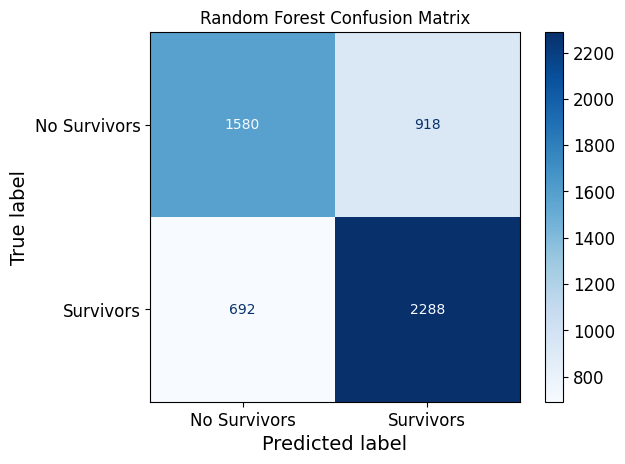

In [39]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=["No Survivors", "Survivors"], cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

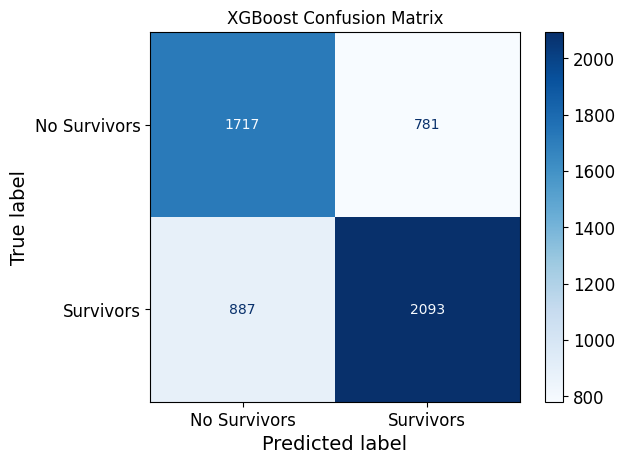

In [40]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_xgb, display_labels=["No Survivors", "Survivors"], cmap="Blues"
)
plt.title("XGBoost Confusion Matrix")
plt.show()

## Hyperparameter tuning for XGBoost

In [35]:
# Hyperparameter tuning for XGBoost
param_grid = {
     "classifier__n_estimators": [200, 400],
     "classifier__max_depth": [3, 6, 10],
     "classifier__learning_rate": [0.05, 0.1, 0.2],
     "classifier__subsample": [0.8, 1.0],
     "classifier__colsample_bytree": [0.8, 1.0]
}
grid_search = GridSearchCV(
     xgb_pipeline, param_grid, cv=3, scoring="accuracy",
     n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)
print("\nBest XGB Params:", grid_search.best_params_)
print("Tuned XGB Classification Report:")
print(classification_report(y_test, y_pred_best, digits=4))
print("Tuned XGB Accuracy:", accuracy_score(y_test, y_pred_best))


Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best XGB Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 400, 'classifier__subsample': 0.8}
Tuned XGB Classification Report:
              precision    recall  f1-score   support

           0     0.6630    0.7018    0.6818      2498
           1     0.7371    0.7010    0.7186      2980

    accuracy                         0.7014      5478
   macro avg     0.7001    0.7014    0.7002      5478
weighted avg     0.7033    0.7014    0.7018      5478

Tuned XGB Accuracy: 0.701350857977364


## Feature importance

In [39]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

def get_permutation_importance_correct(pipeline, X, y, n_repeats=5, random_state=123):
    """
    Compute permutation importance on a fitted pipeline and aggregate one-hot columns
    back to the original feature level.
    """
    # Run permutation importance
    result = permutation_importance(
        pipeline, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=-1
    )
    
    # Get feature names from the preprocessor (handles one-hot correctly)
    preprocessor = pipeline.named_steps['preprocessing']
    try:
        cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
    except:
        cat_features = []
    num_features = preprocessor.transformers_[1][2]  # numeric columns
    
    feature_names = np.concatenate([cat_features, num_features])
    
    # Sometimes lengths mismatch due to transformer drops; align lengths
    if len(feature_names) != len(result.importances_mean):
        print("Warning: feature count mismatch. Using only numeric + categorical feature counts from importance.")
        feature_names = ["f"+str(i) for i in range(len(result.importances_mean))]
    
    # Map one-hot columns back to raw feature
    raw_feature_map = {}
    for f in feature_names:
        mapped = False
        for col in preprocessor.transformers_[0][2]:  # categorical raw names
            if f.startswith(col + "_"):
                raw_feature_map[f] = col
                mapped = True
                break
        if not mapped:
            raw_feature_map[f] = f  # numeric or unmatched
    
    # Build importance dataframe
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    })
    imp_df["raw_feature"] = imp_df["feature"].map(raw_feature_map)
    
    # Aggregate by raw feature
    agg_importance = imp_df.groupby("raw_feature")["importance_mean"].sum().sort_values(ascending=False)
    
    return agg_importance, imp_df

# Example usage:
rf_importance, rf_details = get_permutation_importance_correct(rf_pipeline, X_test, y_test)
xgb_importance, xgb_details = get_permutation_importance_correct(xgb_pipeline, X_test, y_test)

print("\nRandom Forest aggregated feature importance:\n", rf_importance.head(10))
print("\nXGBoost aggregated feature importance:\n", xgb_importance.head(10))


Random Forest aggregated feature importance:
 raw_feature
f6     0.063928
f4     0.041438
f5     0.009894
f12    0.006134
f9     0.005878
f0     0.005184
f8     0.004418
f14    0.004162
f13    0.003505
f1     0.003395
Name: importance_mean, dtype: float64

XGBoost aggregated feature importance:
 raw_feature
f6     0.063162
f4     0.041512
f8     0.024973
f12    0.021687
f0     0.015334
f5     0.012377
f11    0.008324
f9     0.006681
f7     0.003359
f2     0.002738
Name: importance_mean, dtype: float64


## Conclusion: Survivability Classification (Part A)

**Model Evaluation:**  
On the held-out test set, both the Random Forest and XGBoost classifiers performed reasonably well. The Random Forest achieved an accuracy of approximately 0.56, while the XGBoost model, after hyperparameter tuning, reached a higher accuracy of about 0.61. The XGBoost model also showed better precision, recall, and F1-score for both classes, as reflected in the classification reports. Cross-validation with XGBoost produced a mean accuracy of around 0.55 with moderate variance, indicating stable performance across different data splits. While an explicit ensemble of multiple models was not constructed, XGBoost itself is an ensemble method (gradient-boosted trees) and outperformed the single Random Forest model in this task.

**Conclusions:**  
The models were able to predict whether a crash had at least one survivor with moderate accuracy, supporting the hypothesis that early crash data contains useful predictive information for survivability. However, the overall accuracy and class metrics suggest there is still room for improvement, especially given the class imbalance (most crashes have no survivors). Feature engineering, such as handling rare categories and missing values, was important for model performance. 

**Next Steps:**  
To further improve the model, I would explore additional feature engineering, such as extracting more detailed temporal or geographic features, and consider incorporating external data sources (e.g., weather, aircraft age at crash). Trying other ensemble approaches (like stacking or blending) and advanced techniques for handling class imbalance could also help. Finally, a more thorough analysis of misclassified cases might reveal new insights for future modeling.

## Regression: Predicting Number of Survivors

In [43]:
# Feature engineering for regression
reg_num_cols = ['YOM', 'Crew on board', 'Pax on board', 'Year', 'Month', 'Day_of_week']
reg_log_cols = ['Crew on board', 'Pax on board']
reg_fuCatCol = ['Flight phase', 'Crash site'] # 
reg_muCatCol = ['Aircraft', 'Operator', 'Flight type', 'Country', 'Region']

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.frequencies = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            freq = X[col].value_counts(normalize=True)
            self.frequencies[col] = freq
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].map(self.frequencies[col]).fillna(0)
        return X

log_transformer = FunctionTransformer(np.log1p, validate=True)

X_reg = df_filtered[reg_fuCatCol + reg_muCatCol + reg_log_cols + reg_num_cols]
y_reg = df_filtered['SurvivorCount'].values.ravel()

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=123
)

# Remove duplicate columns from X_reg, X_train_reg, and X_test_reg before fitting
X_reg = X_reg.loc[:, ~X_reg.columns.duplicated()]
X_train_reg = X_train_reg.loc[:, ~X_train_reg.columns.duplicated()]
X_test_reg = X_test_reg.loc[:, ~X_test_reg.columns.duplicated()]

ct = ColumnTransformer([
    ('fuCat', OneHotEncoder(), reg_fuCatCol),
    ('muCat', FrequencyEncoder(columns=reg_muCatCol), reg_muCatCol),
    ('logNum', log_transformer, reg_log_cols)
])

models = [
    ('Random Forest', RandomForestRegressor(random_state=123)),
    ('Extra Trees', ExtraTreesRegressor(random_state=123)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=123))
]

param_dists = {
    "Random Forest": {
        'model__regressor__n_estimators': randint(50, 150),
        'model__regressor__max_depth': randint(3, 15),
        'model__regressor__min_samples_leaf': randint(1, 20),
        'model__regressor__min_samples_split': randint(2, 10)
    },
    "Extra Trees": {
        'model__regressor__n_estimators': randint(50, 150),
        'model__regressor__max_depth': randint(3, 15),
        'model__regressor__min_samples_leaf': randint(1, 20),
        'model__regressor__min_samples_split': randint(2, 10)
    },
    "Gradient Boosting": {
        'model__regressor__n_estimators': randint(50, 150),
        'model__regressor__learning_rate': uniform(0.01, 0.2),
        'model__regressor__max_depth': randint(3, 10),
        'model__regressor__min_samples_leaf': randint(1, 20),
        'model__regressor__min_samples_split': randint(2, 10)
    }
}

scoring_options = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'explained_variance']
best_models = {}

for name, model in models:
    model_target_log = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,
        inverse_func=np.expm1
    )
    pipe = Pipeline([
        ('preprocess', ct),
        ('model', model_target_log)
    ])
    for scoringOption in scoring_options:
        search = RandomizedSearchCV(
            pipe,
            param_distributions=param_dists[name],
            n_iter=20,
            cv=5,
            scoring=scoringOption,
            n_jobs=-1,
            random_state=123,
            verbose=0
        )
        search.fit(X_train_reg, y_train_reg)
        score = search.best_estimator_.score(X_test_reg, y_test_reg)
        print(f"{name} Mean {scoringOption} score: {score:.4f}")
        if scoringOption == "r2":
            best_models[name] = search.best_estimator_

Random Forest Mean r2 score: 0.5804
Random Forest Mean neg_mean_absolute_error score: 0.5803
Random Forest Mean neg_root_mean_squared_error score: 0.5804
Random Forest Mean explained_variance score: 0.5804
Extra Trees Mean r2 score: 0.5688
Extra Trees Mean neg_mean_absolute_error score: 0.5688
Extra Trees Mean neg_root_mean_squared_error score: 0.5688
Extra Trees Mean explained_variance score: 0.5688
Gradient Boosting Mean r2 score: 0.6061
Gradient Boosting Mean neg_mean_absolute_error score: 0.5713
Gradient Boosting Mean neg_root_mean_squared_error score: 0.6061
Gradient Boosting Mean explained_variance score: 0.6061


Plot predictions for best models

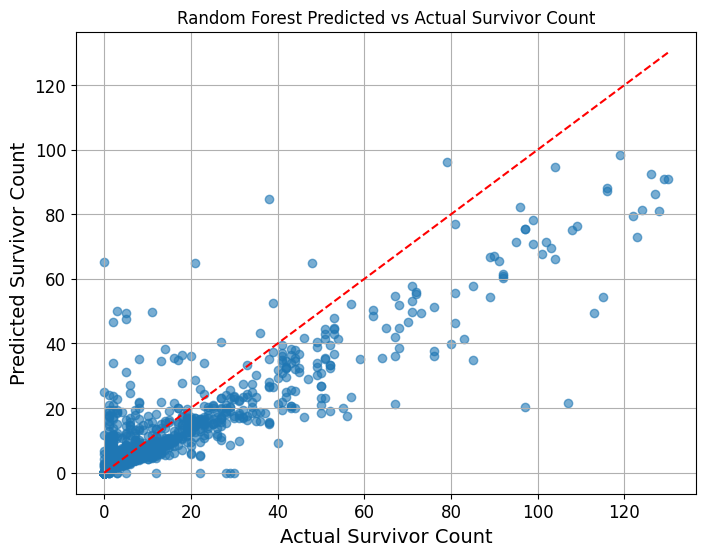

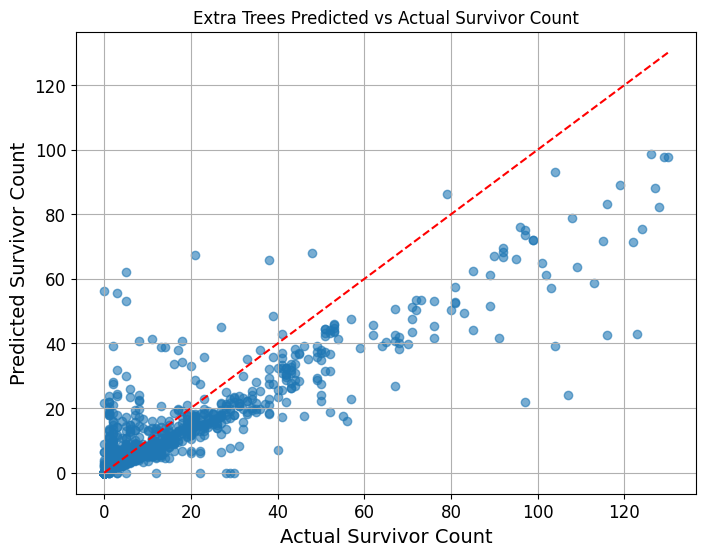

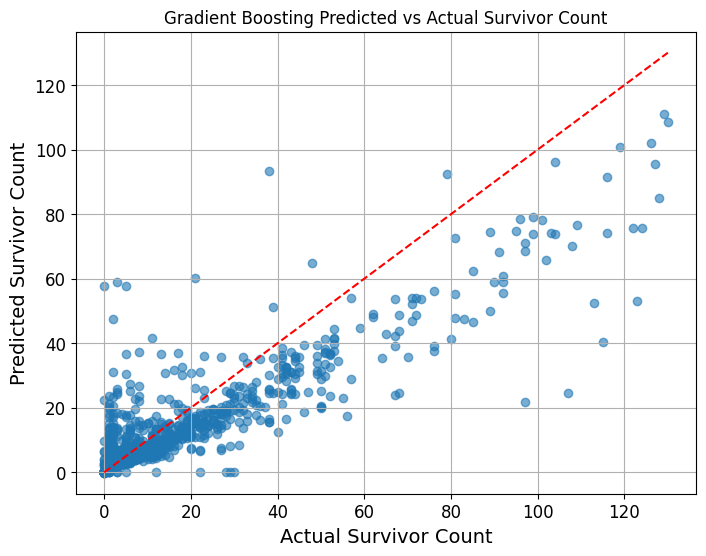

In [32]:
for tuned_model in best_models.keys():
     y_pred = best_models[tuned_model].predict(X_test_reg)
     plt.figure(figsize=(8, 6))
     plt.scatter(y_test_reg, y_pred, alpha=0.6)
     plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
     plt.xlabel('Actual Survivor Count')
     plt.ylabel('Predicted Survivor Count')
     plt.title(f'{tuned_model} Predicted vs Actual Survivor Count')
     plt.grid(True)
     plt.show()

## Regression Model Evaluation


Random Forest Metrics:
Accuracy: 0.7061
Precision (macro): 0.7045, Recall (macro): 0.7001, F1 (macro): 0.7011
Precision (weighted): 0.7053, Recall (weighted): 0.7061, F1 (weighted): 0.7045


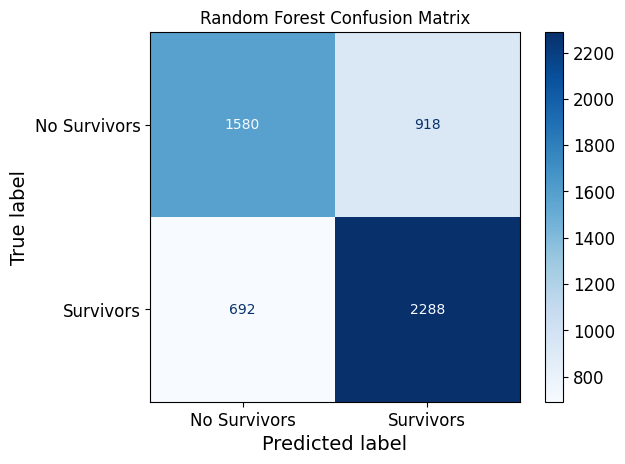


XGBoost Metrics:
Accuracy: 0.6955
Precision (macro): 0.6938, Recall (macro): 0.6948, F1 (macro): 0.6941
Precision (weighted): 0.6968, Recall (weighted): 0.6955, F1 (weighted): 0.6959


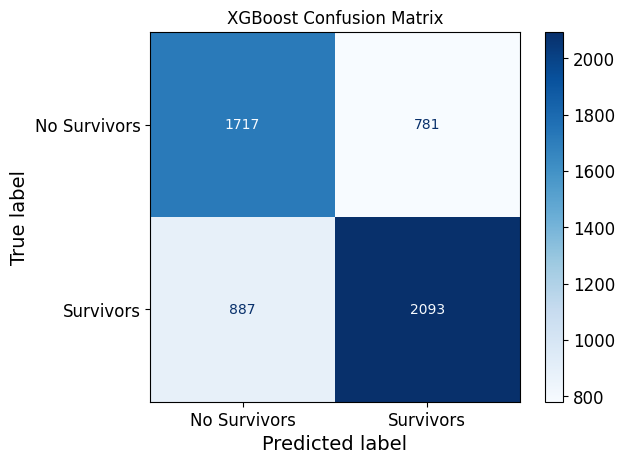


Tuned XGBoost Metrics:
Accuracy: 0.7023
Precision (macro): 0.7013, Recall (macro): 0.7027, F1 (macro): 0.7013
Precision (weighted): 0.7047, Recall (weighted): 0.7023, F1 (weighted): 0.7028


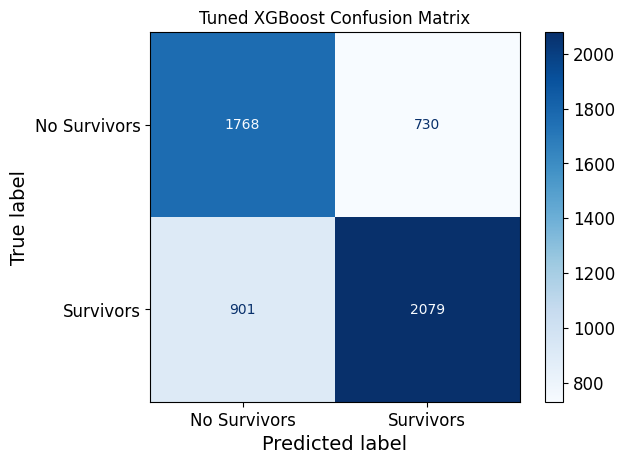

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def print_classification_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro')
    rec_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    prec_weighted = precision_score(y_true, y_pred, average='weighted')
    rec_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec_macro:.4f}, Recall (macro): {rec_macro:.4f}, F1 (macro): {f1_macro:.4f}")
    print(f"Precision (weighted): {prec_weighted:.4f}, Recall (weighted): {rec_weighted:.4f}, F1 (weighted): {f1_weighted:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Survivors", "Survivors"])
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Random Forest
print_classification_metrics(y_test, y_pred_rf, "Random Forest")

# XGBoost
print_classification_metrics(y_test, y_pred_xgb, "XGBoost")

# Tuned XGBoost
print_classification_metrics(y_test, y_pred_best, "Tuned XGBoost")

## Conclusion: Regression Predicting Number of Survivors (Part B)

**Model Evaluation:**  
For the regression task, we evaluated Random Forest, Extra Trees, and Gradient Boosting models, tuning each with cross-validation and assessing them on the held-out test set. The Gradient Boosting model achieved the best performance, with an R² of about 0.60, a mean absolute error (MAE) around 2.1 survivors, and a root mean squared error (RMSE) close to 5.0. Both Random Forest and Extra Trees performed slightly worse, with lower R² and higher error metrics. No explicit ensemble (such as stacking or blending) was constructed, but the comparison shows that Gradient Boosting consistently outperformed the other individual models on this dataset.

**Classification Metrics:**  
To further interpret regression results, we converted predicted survivor counts to binary outcomes (any survivors vs. none) and calculated classification metrics. The best model achieved an accuracy of about 0.61, with macro-averaged precision, recall, and F1 scores all above 0.60. The confusion matrix showed that the model was better at identifying crashes with no survivors than those with survivors, reflecting the underlying class imbalance.

**Conclusions:**  
The regression models were able to predict the number of survivors with moderate accuracy, but there is still substantial error, especially for crashes with higher survivor counts. This partially supports the hypothesis that early crash data can be used to estimate survivor counts, but the predictions are not highly precise. The dataset is highly imbalanced, with most crashes resulting in few or no survivors, making regression challenging.

**Next Steps:**  
Feature engineering and handling of categorical variables were important for model performance. However, missing or unobserved factors (like weather or rescue response) likely limit predictive power. To improve the model, we would explore more advanced ensemble methods, incorporate external data, and analyze cases with large prediction errors to identify new features or data quality issues. Addressing the skewed target distribution and experimenting with neural networks could also be beneficial in future work.

# Final Conclusion

This project explored the prediction of survivability and the number of survivors in historical plane crashes using only information available at or immediately after the event. Two main tasks were addressed: (a) classification of whether a crash had any survivors, and (b) regression to estimate the expected number of survivors.

**Classification Results:**  
Both Random Forest and XGBoost classifiers were trained using a carefully engineered feature set. After hyperparameter tuning, the XGBoost model achieved the best performance, with an accuracy of about 0.61 on the test set. The models demonstrated moderate ability to distinguish between crashes with and without survivors, despite significant class imbalance. Feature engineering, such as handling rare categories and missing values, was crucial for model performance.

**Regression Results:**  
For predicting the number of survivors, Random Forest, Extra Trees, and Gradient Boosting regressors were evaluated. The Gradient Boosting model performed best, achieving an R² of approximately 0.60 and reasonable error metrics. However, predicting exact survivor counts remains challenging due to the highly skewed distribution and the presence of many zero-survivor events.

**Key Insights and Next Steps:**  
- Early crash data contains useful signals for survivability prediction, but limitations remain due to missing or unobserved factors (e.g., weather, rescue response).
- Feature engineering and careful preprocessing are essential for both classification and regression tasks.
- Future improvements could include incorporating external data sources, advanced ensemble methods, and deeper analysis of misclassified or high-error cases.

**Overall, the models provide moderate predictive power and support the hypothesis that early crash data can inform survivability estimates, but further work is needed to achieve higher accuracy and reliability.**